<a href="https://colab.research.google.com/github/Manwi23/WILD/blob/ccolab/WILD_MLProjectReport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Run the cells below if you want to experiment with the code yourself:

In [1]:
!git clone https://github.com/Manwi23/WILD.git
%cd WILD
!git checkout ccolab
!pip install selenium
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver .

Cloning into 'WILD'...
remote: Enumerating objects: 148, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 426 (delta 100), reused 114 (delta 73), pack-reused 278
Receiving objects: 100% (426/426), 49.18 MiB | 17.51 MiB/s, done.
Resolving deltas: 100% (258/258), done.
/content/WILD
Checking out files: 100% (97/97), done.
Branch 'ccolab' set up to track remote branch 'ccolab' from 'origin'.
Switched to a new branch 'ccolab'
     |████████████████████████████████| 911kB 6.4MB/s 
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  R

In [3]:
from moreMeasurePoints import single_location, multi_location, current_weather
from explore import collect_statistics
import pandas as pd
import scipy.stats as sstats
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt

# Section 1 - comparing different models

In this part we compare the performance of Ridge Regression, XGBoost and our small neural network on datasets that use different time intervals between measurements and use either data from Wrocław only (single_location) or Wrocław, Dresden, Poznan, Katowice and Prague (multi_location).

In each case, the task is the same - to predict the difference between the temperature 12h after - 12h before the last observation in Wrocław. In other words, we make a 12h temperature forecast, where temperature is encoded as the difference between the current temperature and temperature 24h ago.

Additionaly, we also show expected temperature changes given wind and condition statistics for single_location case from our previous progress report.

**IMPORTANT** if you want to run the code in either Section 1 and Section 2, don't do it at the same time, as it might use all memory in Colab. Also, running them will take at least several minutes each.

In [ ]:
single_loc_models = single_location()

In [ ]:
multi_loc_models = multi_location()

In [ ]:
scores = []

for mgname, mgroup in [("single",single_loc_models), ("multi",multi_loc_models)]:
    for td in mgroup:
        for m in mgroup[td]:
            model = mgroup[td][m]
            # print(td//2, m)
            err = model.compute_errors(model.test_df)
            mu, sigma = sstats.norm.fit(err)
            lowerInterval = sstats.norm.ppf(0.10, mu, sigma)
            upperInterval = sstats.norm.ppf(0.90, mu, sigma)
            if m == "linear":
                scores.append([mgname, td//2, m, model.compute_score(model.train_df), 0, model.compute_score(model.test_df),  upperInterval- lowerInterval])
            else:
                scores.append([mgname, td//2, m, model.compute_score(model.train_df), model.compute_score(model.val_df), model.compute_score(model.test_df),  upperInterval- lowerInterval])

scores_df = pd.DataFrame(scores, columns=["locations", "time delta", "model", "train", "validation", "test", "confidence interval (80%) width"])
scores_df.sort_values("test", ascending=False)

,locations,time delta,model,train,validation,test,confidence interval (80%) width
23,multi,6,neuralnet,0.798870,0.504418,0.442866,6.712424
20,multi,4,neuralnet,0.791565,0.506711,0.423077,6.818243
26,multi,12,neuralnet,0.818547,0.497172,0.422009,6.763336
19,multi,4,xgboost,0.677713,0.316194,0.408797,6.907582
25,multi,12,xgboost,0.694819,0.316444,0.399417,6.892819
11,single,12,neuralnet,0.542388,0.420647,0.384746,7.128584
21,multi,6,linear,0.573186,0.000000,0.382178,7.053950
5,single,4,neuralnet,0.533043,0.393020,0.381706,7.130018
24,multi,12,linear,0.586360,0.000000,0.379142,6.983328
22,multi,6,xgboost,0.681297,0.287304,0.365179,7.161217


Train, validation and test scores are computed as follows: 

$score = \frac{MSE(prediction, target)}{MSE(mean(target), target)}$

Time delta is shown in hours, confidence bounds are in degrees Celsius.

Observations:
*   Neural nets outperform both XGBoost and Ridge regression. 
*   Models trained on multilocation data perform better.
*   Models trained on data with 2h and 24h intervals perform much worse than others - this is because they don't include the data from 24h before the target time, which is the most important predictor.



The problem is quite difficult and the differences between the best and worst model are quite slim, as presented on the histogram below.

Errors on test data - best and worst model


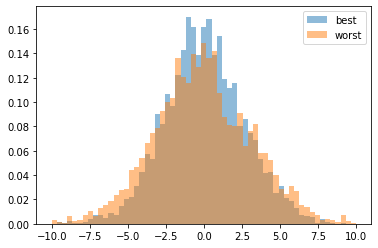

In [ ]:
best_model = multi_loc_models[12]["neuralnet"]
worst_model = single_loc_models[48]["xgboost"]

best_err = best_model.compute_errors(best_model.test_df)
worst_err = worst_model.compute_errors(worst_model.test_df)

bins = np.linspace(-10, 10, 60)

pyplot.hist(best_err, bins, alpha=0.5, label='best', density=True)
pyplot.hist(worst_err, bins, alpha=0.5, label='worst', density=True)
pyplot.legend(loc='upper right')
print("Errors on test data - best and worst model")
pyplot.show()

Errors on train data - best and worst model


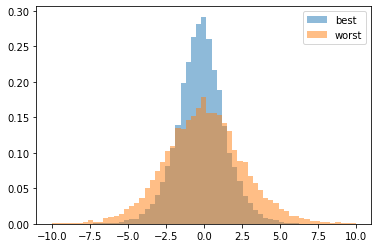

In [ ]:
best_err = best_model.compute_errors(best_model.train_df)
worst_err = worst_model.compute_errors(worst_model.train_df)

bins = np.linspace(-10, 10, 60)

pyplot.hist(best_err, bins, alpha=0.5, label='best', density=True)
pyplot.hist(worst_err, bins, alpha=0.5, label='worst', density=True)
pyplot.legend(loc='upper right')
print("Errors on train data - best and worst model")
pyplot.show()

Errors on test and train data- best model


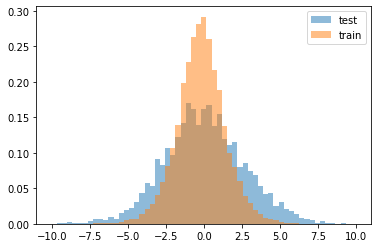

In [ ]:
best_test_err = best_model.compute_errors(best_model.test_df)
best_train_err = best_model.compute_errors(best_model.train_df)

bins = np.linspace(-10, 10, 60)

pyplot.hist(best_test_err, bins, alpha=0.5, label='test', density=True)
pyplot.hist(best_train_err, bins, alpha=0.5, label='train', density=True)
pyplot.legend(loc='upper right')
print("Errors on test and train data- best model")
pyplot.show()

Statistics for single-location, single-observation case in Wrocław. There is a clearly visible correlation between wind direction and predicted temperature change in 24h. Note that the confidence bounds here are the bounds on *the average*, not on the data itself. 

In [ ]:
wind, cond, time = collect_statistics()

In [5]:
wind

,mean,95% low,95% high,count
Wind,,,,
W,-0.289469,-0.412293,-0.166646,3445
WNW,-0.537641,-0.682011,-0.393272,2543
SE,1.337547,1.200489,1.474606,2505
WSW,0.454457,0.285620,0.623293,1709
SSE,1.130823,0.969980,1.291667,1691
SW,0.680163,0.516933,0.843393,1663
VAR,0.179936,0.015625,0.344246,1658
ESE,0.730453,0.565576,0.895329,1512
S,1.223106,1.045191,1.401022,1508


In [6]:
cond

,mean,95% low,95% high,count
Condition,,,,
Fair,0.340855,0.275927,0.405783,11419
Mostly Cloudy,-0.237438,-0.331961,-0.142914,5068
Mist,0.349231,0.199009,0.499454,1901
Light Rain,0.052117,-0.135796,0.240030,1567
Partly Cloudy,-0.542127,-0.748437,-0.335817,1117
Light Snow,-0.169967,-0.394264,0.054330,1010
Cloudy,-0.257295,-0.484469,-0.030120,773
Fog,1.357769,1.061418,1.654120,482
Mostly Cloudy / Windy,-1.639785,-2.065420,-1.214150,310


# Section 2 - live prediction

You can run all the cells below to see the comparison between selected models on live data. 

In [ ]:
models = multi_location(rain=False)

In [ ]:
ans, true_value = current_weather(models, multiple_locations=["wroclaw", "poznan", "katowice", "prague", "dresden"])

This plot shows the model prediction overlaid with the true data from the last 6 calendar days. 

X axis units are 30min, Y axis are degrees Celsius. The "ground truth" line represents the true values at given time (the value model is trying to predict), the "same as 24 hours ago" shows the result of a dummy model that always predicts 0 in our encoding, in other words assumes the temperature will be the same as it was 24 hours ago.

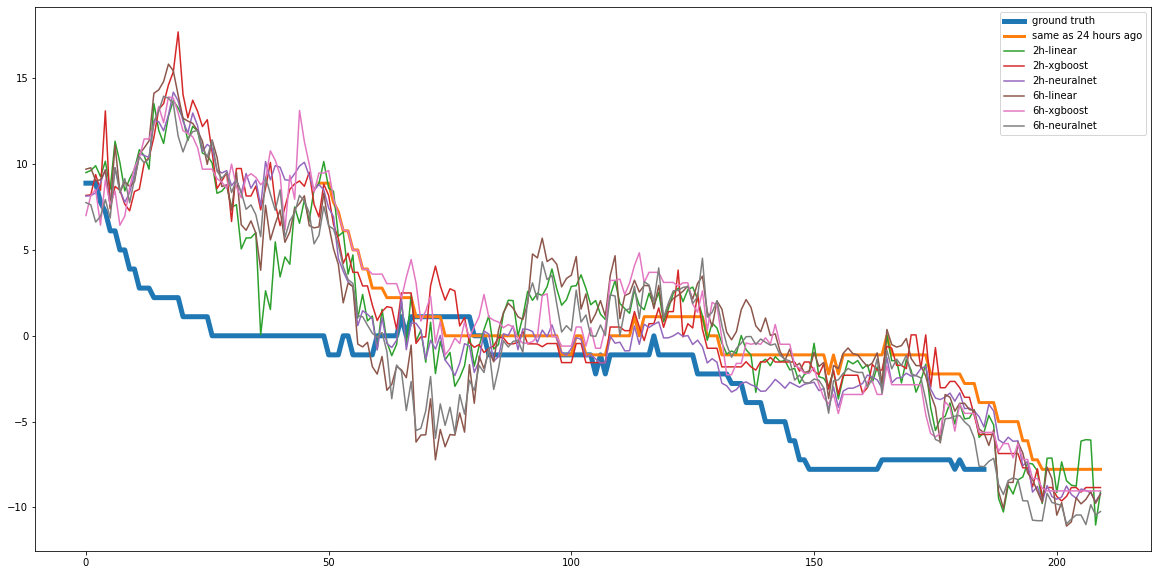

In [ ]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.plot(true_value.to_numpy()[-210+24:], label=f"ground truth", linewidth=5)
plt.plot(range(48,210), true_value.to_numpy()[-210+24:-24], label=f"same as 24 hours ago", linewidth=3)


for td in [4,12]:
    for m in ans[td]:
        plt.plot(ans[td][m][-210:], label=f"{td//2}h-{m}")
plt.legend()
plt.show()

This line prints the decoded output of our best model for the most recent weather data and predicts what will be the temperature in 12 hours in degrees Celsius.

In [ ]:
print("In 12 hours, the temperature will be", ans[12]["neuralnet"][-1])

In 12 hours, the temperature will be -10.234820710288155
